In [1]:
# Get files
# from zipfile import ZipFile

# file_name = "ucsc-cse-164-spring-2024-final-project.zip"

# with ZipFile(file_name, 'r') as zip:
#     zip.extractall()

In [1]:
import pandas as pd
from PIL import Image
import os
import torch
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torchvision.io import read_image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
# Training data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')  # Use PIL to open the image
        label = torch.tensor(self.img_labels.iloc[idx, 1])  # Convert label to tensor
        if self.transform:
            image = self.transform(image)
        return image, label

class CustomImageDatasetWithIntLabels(CustomImageDataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        super().__init__(annotations_file, img_dir, transform)
        self.img_labels['label'] = self.img_labels['label'].astype(int)  # Convert labels to integers



In [5]:
trainLabeledDir='ucsc-cse-164-spring-2024-final-project/train/labeled'
trainLabeledCSV='ucsc-cse-164-spring-2024-final-project/train_labeled.csv'
# Create a custom dataset
train_data = CustomImageDataset(csv_file=trainLabeledCSV, img_dir=trainLabeledDir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


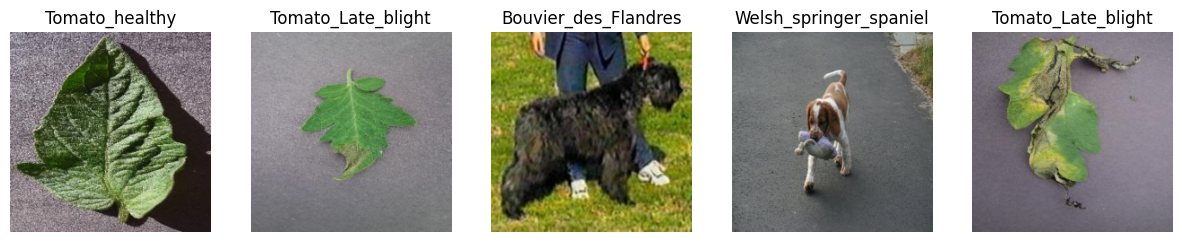

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# Get a batch of training data
images, labels = next(iter(train_dataloader))

def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        ax = plt.gca()
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

# Define the categories
categories = pd.read_csv('ucsc-cse-164-spring-2024-final-project/categories.csv')
category_dict = categories.set_index('id').to_dict()['category']

# Plot the images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    imshow(images[i], ax=axs[i], title=category_dict[int(labels[i].item())])  # Use .item() to get the value of the tensor

plt.show()



In [7]:
from torchvision.models import resnet18
from torchvision.models import vgg16
from torchvision.models import densenet121

# Define the model
model = resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 135)
model = model.to(device)


In [8]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
from tempfile import TemporaryDirectory
import os
import time
# From CSE144 Final
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train_dataloader
                    model.train()  # Set model to training mode
                else:
                    dataloader = val_dataloader
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = running_corrects.double() / len(dataloader.dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
train_model(model, criterion, optimizer, num_epochs=15)

In [ ]:
# torch.save(model.state_dict(), 'PRbest.pth')

In [ ]:
# model.load_state_dict(torch.load('PRbest.pth'))  # Load the parameters
# model = model
# model.to(device)  # Move the model to GPU if available

In [12]:
# Define the unlabeled dataset
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_list = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx): 
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        image = Image.open(img_path).convert('RGB')  # Use PIL to open the image
        if self.transform:
            image = self.transform(image)
        return image

# Create the unlabeled dataset
unlabeled_dataset = UnlabeledDataset(img_dir='ucsc-cse-164-spring-2024-final-project/train/unlabeled', transform=transform)
# Create the unlabeled dataloader
unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

In [27]:
def generate_pseudo_labels(model, unlabeled_dataloader, confidence_threshold):
    model.eval()  # Set the model to evaluation mode
    # Initialize lists for unlabeled images and pseudo labels
    unlabeled_images = []
    pseudo_labels_list = []
    # Load existing pseudo labels
    try:
        existing_pseudo_labels = pd.read_csv('unlabeled_with_pseudo_labels.csv')
        existing_images = set(existing_pseudo_labels['image'])
    except FileNotFoundError:
        existing_images = set()
    with torch.no_grad():  # No need to calculate gradients
        for i, images in enumerate(unlabeled_dataloader):
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)  # Calculate class probabilities
            max_probs, pseudo_labels = torch.max(probabilities, 1)  # Get max probabilities and corresponding labels
            
            for image, pseudo_label, max_prob in zip(unlabeled_dataset.image_list[i*unlabeled_dataloader.batch_size:(i+1)*unlabeled_dataloader.batch_size], pseudo_labels, max_probs):
                # Only append labels where max probability is above the threshold and the image is not already labeled
                if max_prob.item() > confidence_threshold and image not in existing_images:
                    unlabeled_images.append(image)
                    pseudo_labels_list.append(pseudo_label.item())
    # Create a DataFrame and save it as a CSV file
    df = pd.DataFrame({
        'image': unlabeled_images,
        'label': pseudo_labels_list
    })
        # Check if the file exists
    if os.path.exists('unlabeled_with_pseudo_labels.csv'):
        # If it exists, append without writing headers
        df.to_csv('unlabeled_with_pseudo_labels.csv', mode='a', header=False, index=False)
    else:
        # If it doesn't exist, create the file and write headers
        df.to_csv('unlabeled_with_pseudo_labels.csv', mode='w', header=True, index=False)

In [45]:
num_iterations = 1

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}")
    # Generate pseudo-labels for unlabeled data
    generate_pseudo_labels(model, unlabeled_dataloader,0.90)
    # Combine the datasets
    pseudo_labeled_dataset = CustomImageDatasetWithIntLabels(annotations_file='unlabeled_with_pseudo_labels.csv', img_dir='ucsc-cse-164-spring-2024-final-project/train/unlabeled', transform=transform)
    combined_dataset = torch.utils.data.ConcatDataset([train_dataset, pseudo_labeled_dataset])
    train_dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=32, shuffle=True)
    train_model(model, criterion, optimizer, num_epochs=10) # train on pseudolabeled and labeled data

Iteration 1
631
Epoch 0/9
----------
train Loss: 0.0890 Acc: 0.9741
val Loss: 3.7517 Acc: 0.5652

Epoch 1/9
----------
train Loss: 0.0389 Acc: 0.9887
val Loss: 3.6492 Acc: 0.5718

Epoch 2/9
----------
train Loss: 0.0262 Acc: 0.9930
val Loss: 3.8018 Acc: 0.5713

Epoch 3/9
----------
train Loss: 0.0296 Acc: 0.9920
val Loss: 3.7991 Acc: 0.5596

Epoch 4/9
----------
train Loss: 0.0305 Acc: 0.9913
val Loss: 3.8161 Acc: 0.5642

Epoch 5/9
----------
train Loss: 0.0228 Acc: 0.9942
val Loss: 3.9588 Acc: 0.5581

Epoch 6/9
----------
train Loss: 0.0367 Acc: 0.9897
val Loss: 3.9049 Acc: 0.5525

Epoch 7/9
----------
train Loss: 0.0248 Acc: 0.9937
val Loss: 4.2196 Acc: 0.5439

Epoch 8/9
----------
train Loss: 0.0278 Acc: 0.9918
val Loss: 3.9966 Acc: 0.5561

Epoch 9/9
----------
train Loss: 0.0241 Acc: 0.9934
val Loss: 3.8761 Acc: 0.5647

Training complete in 40m 16s
Best val Acc: 0.571791


In [46]:
def predict_test_images(model, device, test_dir, transform): # predict test images
    model.eval()  # Set the model to evaluation mode
    image_list = os.listdir(test_dir)
    predictions = []

    with torch.no_grad():  # No need to calculate gradients
        for image_file in image_list:
            image_path = os.path.join(test_dir, image_file)
            image = Image.open(image_path).convert('RGB')
            if transform:
                image = transform(image)
            image = image.to(device)
            output = model(image.unsqueeze(0))
            _, predicted = torch.max(output.data, 1)
            predictions.append(predicted.item())
    # Create a DataFrame and save it as a CSV file
    df = pd.DataFrame({
        'image': image_list,
        'label': predictions
    })
    df.to_csv('test_predictions.csv', index=False)


In [ ]:
predict_test_images(model, device, 'ucsc-cse-164-spring-2024-final-project/test', transform)